<a href="https://colab.research.google.com/github/Lavi-hk/Predicting-E.-coli-Presence-and-Resistance-in-Environmental-Samples-Using-Machine-Learning-Models/blob/main/Team_1_ML_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

# Step 1: Extract ZIP file

In [ ]:
zip_path = "/content/0239cdaf-deab-4151-8f68-715063eaea45.zip"  # Update the file path if needed
extract_folder = "/content/dataset_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Files extracted successfully!")


Files extracted successfully!


# Step 2: Verify extracted files

In [ ]:
print("Extracted files:", os.listdir(extract_folder))

Extracted files: ['0239cdaf-deab-4151-8f68-715063eaea45']


# Step 3: Define the CSV path

In [ ]:
csv_path = f"{extract_folder}/0239cdaf-deab-4151-8f68-715063eaea45/data/Ecolicounts.csv"

# Step 4: Load dataset

In [ ]:
if os.path.exists(csv_path):
    ecoli_data = pd.read_csv(csv_path)
    print("Dataset loaded successfully.")
else:
    print("Error: CSV file not found!")

Dataset loaded successfully.


# Step 5: Handle missing values (fill NaN with median for numeric columns)

In [ ]:
env_columns = ["pH", "Conductivity", "Temp"]
for col in env_columns:
    ecoli_data[col] = ecoli_data[col].fillna(ecoli_data[col].median())

# Step 6: Encode categorical target variable (StatusTBX: Positive/Negative -> 1/0)

In [ ]:
label_encoder = LabelEncoder()
ecoli_data["StatusTBX"] = label_encoder.fit_transform(ecoli_data["StatusTBX"])


# Step 7: Drop unnecessary ID-like columns

In [ ]:
ecoli_data_cleaned = ecoli_data.drop(columns=['PId', 'Uniqueid'], errors='ignore')


# Step 8: Encode any remaining categorical columns

In [ ]:
label_encoders = {}
for col in ecoli_data_cleaned.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    ecoli_data_cleaned[col] = label_encoders[col].fit_transform(ecoli_data_cleaned[col])

# Step 9: Create new engineered features


In [ ]:
# 1. pH Deviation from neutral
ecoli_data_cleaned["pH_deviation"] = np.abs(ecoli_data_cleaned["pH"] - 7)

# 2. Water Quality Index-like feature (WQI-like)
scaler = StandardScaler()
ecoli_data_cleaned[["pH_z", "Cond_z", "Temp_z"]] = scaler.fit_transform(
    ecoli_data_cleaned[["pH", "Conductivity", "Temp"]]
)
ecoli_data_cleaned["WQI_like"] = ecoli_data_cleaned[["pH_z", "Cond_z", "Temp_z"]].mean(axis=1)

# 3. Interaction features
ecoli_data_cleaned["pH_Temp_interact"] = ecoli_data_cleaned["pH"] * ecoli_data_cleaned["Temp"]
ecoli_data_cleaned["Cond_Temp_interact"] = ecoli_data_cleaned["Conductivity"] * ecoli_data_cleaned["Temp"]

# 4. Normalized TBX Count
ecoli_data_cleaned["TBX_normalized"] = (
    ecoli_data_cleaned["TBXcount"] - ecoli_data_cleaned["TBXcount"].mean()
) / ecoli_data_cleaned["TBXcount"].std()

# 5. Ideal Temperature Range Flag (25°C to 37°C)
ecoli_data_cleaned["Ideal_Temp_Range"] = ecoli_data_cleaned["Temp"].between(25, 37).astype(int)


# Step 10: Feature selection

In [ ]:
features = [
    "pH", "Conductivity", "Temp", "TBXcount",
    "pH_deviation", "WQI_like",
    "pH_Temp_interact", "Cond_Temp_interact",
    "TBX_normalized", "Ideal_Temp_Range"
]
target = "StatusTBX"
X = ecoli_data_cleaned[features]
y = ecoli_data_cleaned[target]

Preprocess and Train the Model


# Step 11: Split data into training (80%) and testing (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 12: Train a Random Forest model

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
print(f"Random Forest Accuracy: {accuracy_rf:.2f}%")

Random Forest Accuracy: 100.00%



# Step 13: Train a Logistic Regression model

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
accuracy_log = accuracy_score(y_test, y_pred_log) * 100
print(f"Logistic Regression Accuracy: {accuracy_log:.2f}%")

Logistic Regression Accuracy: 98.00%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Step 14: Train a Gradient Boosting model

In [ ]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb) * 100
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}%")


Gradient Boosting Accuracy: 100.00%


# Step 15: Train a Support Vector Machine (SVM) model

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm) * 100
print(f"SVM Accuracy: {accuracy_svm:.2f}%")

SVM Accuracy: 91.20%


# Step 16: Print classification reports

In [ ]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       228

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        22
           1       1.00      0.98      0.99       228

    accuracy                           0.98       250
   macro avg       0.91      0.99      0.94       250
weighted avg       0.98      0.98      0.98       250

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       228

    accuracy                           1.00       250
   macr

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Step 17: Determine the best model

In [ ]:
accuracies = {
    "Random Forest": accuracy_rf,
    "Logistic Regression": accuracy_log,
    "Gradient Boosting": accuracy_gb,
    "SVM": accuracy_svm
}
best_model = max(accuracies, key=accuracies.get)
print(f"Best Model: {best_model} with Accuracy: {accuracies[best_model]:.2f}%")


Best Model: Random Forest with Accuracy: 100.00%


# Step 18: Shuffle the dataset

In [ ]:
ecoli_data_cleaned = shuffle(ecoli_data_cleaned, random_state=42)


# Step 19: Feature importance analysis (from Random Forest)

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature Importance Ranking:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Feature Importance Ranking:
TBXcount: 0.5833
TBX_normalized: 0.3866
Cond_Temp_interact: 0.0058
pH_deviation: 0.0051
WQI_like: 0.0043
Conductivity: 0.0043
pH: 0.0041
pH_Temp_interact: 0.0038
Temp: 0.0025
Ideal_Temp_Range: 0.0004


# Step 20: Visualize feature correlations

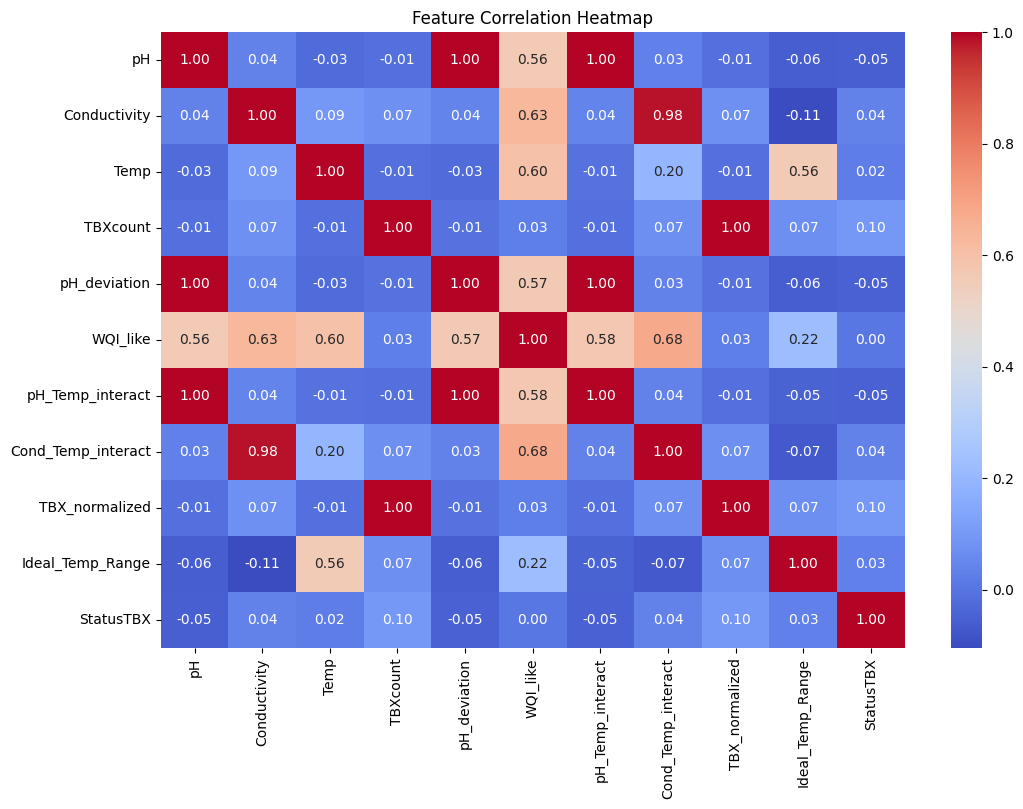

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(ecoli_data_cleaned[features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 21: Visualize TBXcount distribution

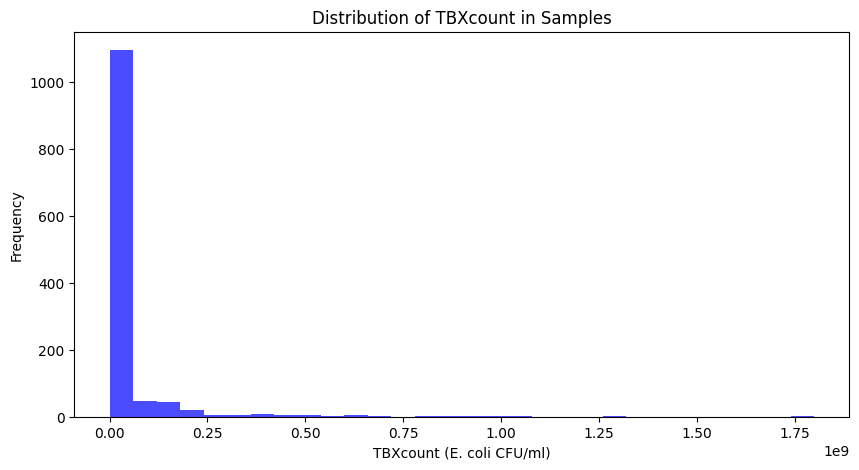

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(ecoli_data_cleaned["TBXcount"], bins=30, color='blue', alpha=0.7)
plt.xlabel("TBXcount (E. coli CFU/ml)")
plt.ylabel("Frequency")
plt.title("Distribution of TBXcount in Samples")
plt.show()

# Step 22: Save the processed dataset

In [ ]:
output_path = "/content/Processed_Ecolicounts.csv"
ecoli_data_cleaned.to_csv(output_path, index=False)
print("Processed dataset saved as", output_path)

Processed dataset saved as /content/Processed_Ecolicounts.csv


In [ ]:
'''🔬 Summary of Added Novel Features:
Feature Name	Description
pH_deviation	Absolute difference from neutral pH (7)
WQI_like	Simplified water quality index using z-scores
pH_Temp_interact	Interaction between pH and temperature
Cond_Temp_interact	Interaction between conductivity and temperature
TBX_normalized	Normalized E. coli count
Ideal_Temp_Range	Binary flag for ideal microbial growth temperature'''

'🔬 Summary of Added Novel Features:\nFeature Name\tDescription\npH_deviation\tAbsolute difference from neutral pH (7)\nWQI_like\tSimplified water quality index using z-scores\npH_Temp_interact\tInteraction between pH and temperature\nCond_Temp_interact\tInteraction between conductivity and temperature\nTBX_normalized\tNormalized E. coli count\nIdeal_Temp_Range\tBinary flag for ideal microbial growth temperature'